In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import pymc3 as pm
import theano.tensor as tt

import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

**1.** Posterior inference: suppose you have a Beta(4, 4) prior distribution on the probability `θ` that a coin will yield a ‘head’ when spun in a specified manner. The coin is independently spun ten times, and ‘heads’ appear fewer than 3 times. You are not told how many heads were seen, only that the number is less than 3. Calculate your exact posterior density (up to a proportionality constant) for `θ` and sketch it.

In [3]:
with pm.Model() as m1:
    th = pm.Beta('th', 4, 4)

    heads = pm.Binomial('heads', n=10, p=th)

    logp = tt.log(
        # probability of heads > 3 is one
        tt.switch(tt.lt(heads, 3), 1, 1e-10)
    )
    
    pm.Potential('obs', logp)

    m1.trace = pm.sample(30_000, tune=2_000, chains=2)

/home/petrushev/etc/jupenv/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [th]
>Metropolis: [heads]


Sampling 2 chains for 2_000 tune and 30_000 draw iterations (4_000 + 60_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


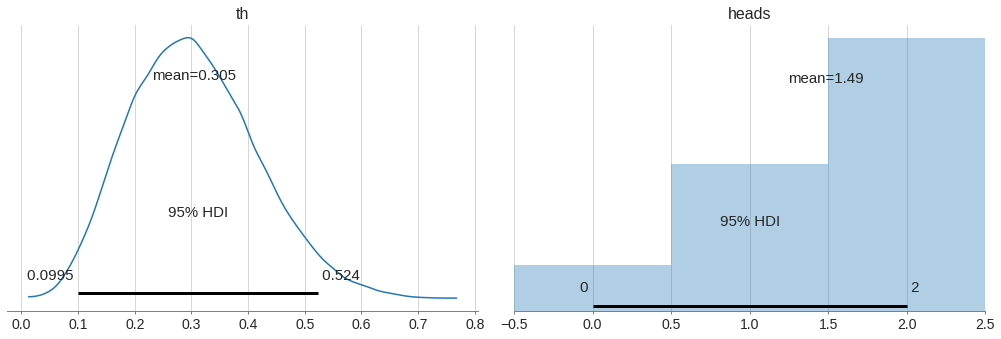

In [8]:
pm.plot_posterior(m1.trace, var_names=['th', 'heads'], hdi_prob=0.95, round_to=3)
None

**2.** Predictive distributions: consider two coins, C1 and C2 , with the following characteristics: `Pr(heads|C1 ) = 0.6` and `Pr(heads|C2 ) = 0.4`. Choose one of the coins at random and imagine spinning it repeatedly. Given that the first two spins from the chosen coin are tails, what is the expectation of the number of additional spins until a head shows up?


In [9]:
with pm.Model() as m2:
    p1 = 0.6
    p2 = 0.4

    # randomly select a coing
    choice = pm.Bernoulli('choice', p=0.5)
    p_chosen = pm.math.switch(pm.math.eq(choice, 0), p1, p2)

    # the number of spins until a head is shown is follows a Geometric distribution
    spins_until_heads = pm.Geometric('spins_until_heads', p_chosen)

    logp = tt.log(
        # the total number of these spins is larger than 2
        tt.switch(tt.gt(spins_until_heads, 2), 1, 1e-10)
    )

    pm.Potential('obs', logp)

    # the additional spins on top of the first two
    additional_spins = pm.Deterministic('additional_spins', spins_until_heads - 2)

    m2.trace = pm.sample(10000, tune=3000)

/home/petrushev/etc/jupenv/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [choice]
>Metropolis: [spins_until_heads]


Sampling 4 chains for 3_000 tune and 10_000 draw iterations (12_000 + 40_000 draws total) took 6 seconds.
The number of effective samples is smaller than 10% for some parameters.


/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


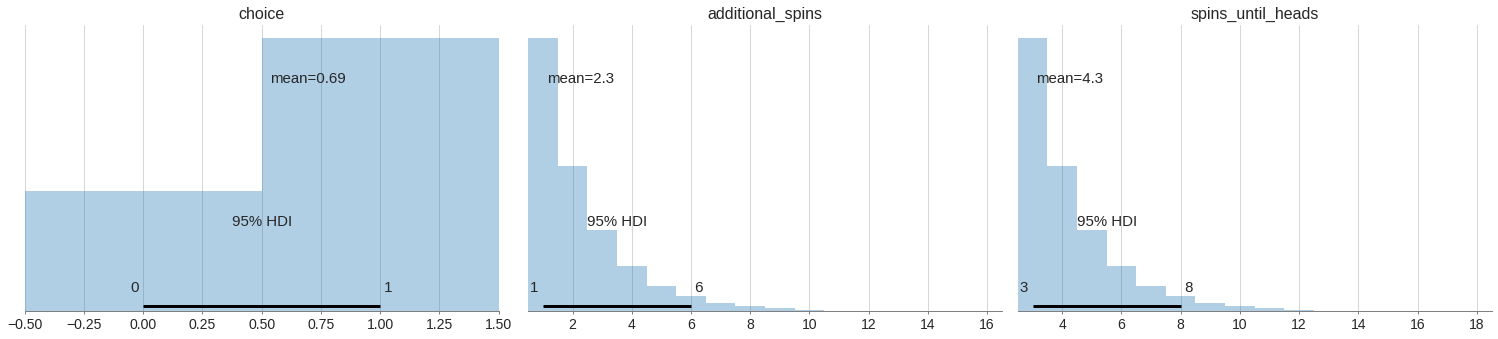

In [11]:
pm.plot_posterior(m2.trace, var_names=['choice', 'additional_spins', 'spins_until_heads'], hdi_prob=0.95)
None